# Assignment 7: MRI Connectivity Analysis
## Computational Methods in Psychology and Neuroscience
### Psychology 4215/7215 --- Fall 2023

# Objectives

Upon completion of this assignment, the student will have:

A. Loaded MRI connectivity data for rest and BART (the balloon analog risk task)

B. Compared functional connectivity between the two tasks


# Assignment

* Write code in a Jupyter notebook (after making a copy and renaming it to have your userid in the title --- e.g., A07_MRI_Connectivity_Analysis_mst3k).

## Details

The goal of this assignment is to visualize differences in functional connectivity between rest and a task (in this case the task is the Balloon Analog Risk Task, or BART). 

I have preprocessed the data into separate time series for regions defined by the Harvard--Oxford database and provided them as a download from Canvas (the filename is `Rest_BART_time_series.npz`, which is a compressed numpy file.) You can see the code I used to preprocess the data in the first handful of cells.

Your assignment is to:

- Read in the time series data (code is provided for that)
- Calculate correlation matrices for the rest and BART time series
- Plot the correlation matrices
- Plot the connectivity graphs for Rest, BART, and Rest-BART
- Discuss what you found
  
* ***When you are done with the analysis, save this notebook as HTML (`File -> Download as -> HTML`) and upload it to the matching assignment on Canvas.***  

In [2]:
# Load some required modules

# import some useful libraries
import numpy as np                # numerical analysis linear algebra
import pandas as pd               # efficient tables
import matplotlib.pyplot as plt   # plotting
from scipy import stats
import os

# import nilearn stuff
from nilearn import plotting, image
from nilearn.maskers import NiftiLabelsMasker
from nilearn import datasets
from nilearn.connectome import ConnectivityMeasure


In [3]:
# load the Harvard Oxford atlas
atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm',
                                             symmetric_split=True)
atlas_filename = atlas.maps
labels = atlas.labels


Dataset created in C:\Users\student/nilearn_data\fsl



Downloaded 17784832 of 25716861 bytes (69.2%,    0.9s remaining) ...done. (3 seconds, 0 min)
Extracting data from C:\Users\student/nilearn_data\fsl\d98583ef74b62014d7f95f191e41aac1\HarvardOxford.tgz..... done.


In [4]:
# extract the coordinates of the atlas regions
coords = plotting.find_parcellation_cut_coords(
    labels_img=atlas_filename)

In [5]:
# Here's what I ran to load the resting data timeseries
"""
masker = NiftiLabelsMasker(
    labels_img=atlas_filename,
    standardize="zscore_sample",
    standardize_confounds="zscore_sample",
    memory="nilearn_cache",
    verbose=5,
)

# define the functional data
epi_file = 's042m.rest.np.preproc.nii.gz'

# calculate the average time_series for each region
time_series_rest = masker.fit_transform(epi_file)
"""

'\nmasker = NiftiLabelsMasker(\n    labels_img=atlas_filename,\n    standardize="zscore_sample",\n    standardize_confounds="zscore_sample",\n    memory="nilearn_cache",\n    verbose=5,\n)\n\n# define the functional data\nepi_file = \'s042m.rest.np.preproc.nii.gz\'\n\n# calculate the average time_series for each region\ntime_series_rest = masker.fit_transform(epi_file)\n'

In [6]:
# Here's what I ran to load the BART data timeseries
"""
masker = NiftiLabelsMasker(
    labels_img=atlas_filename,
    standardize="zscore_sample",
    standardize_confounds="zscore_sample",
    memory="nilearn_cache",
    verbose=5,
)

# define the functional data
epi_file = 's042m.BART.np.preproc.nii.gz'

# calculate the average time_series for each region
time_series_bart = masker.fit_transform(epi_file)
"""

'\nmasker = NiftiLabelsMasker(\n    labels_img=atlas_filename,\n    standardize="zscore_sample",\n    standardize_confounds="zscore_sample",\n    memory="nilearn_cache",\n    verbose=5,\n)\n\n# define the functional data\nepi_file = \'s042m.BART.np.preproc.nii.gz\'\n\n# calculate the average time_series for each region\ntime_series_bart = masker.fit_transform(epi_file)\n'

In [7]:
# Here's how I saved it out
"""
np.savez_compressed('Rest_BART_time_series.npz', 
                    rest=time_series_rest,
                    bart=time_series_bart)
"""

"\nnp.savez_compressed('Rest_BART_time_series.npz', \n                    rest=time_series_rest,\n                    bart=time_series_bart)\n"

In [8]:
# And here's how you read it in
ts = np.load('Rest_BART_time_series.npz')
time_series_rest = ts['rest']
time_series_bart = ts['bart']

In [9]:
print('Rest:', time_series_rest.shape)
print('BART:', time_series_bart.shape)
nsamps = min(len(time_series_rest), len(time_series_bart))
print(nsamps)

# looks like we need to cut off the tail end of the rest,
# so that our correlations are comparable
time_series_rest = time_series_rest[:nsamps, :]

Rest: (594, 96)
BART: (352, 96)
352


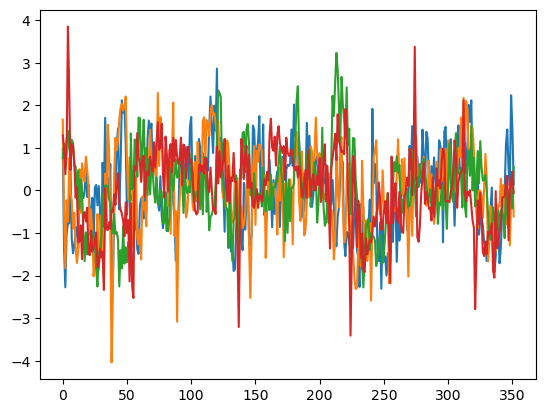

In [10]:
# let's plot a couple to see what they are like
plt.plot(time_series_bart[:,2]);
plt.plot(time_series_bart[:,15]);
plt.plot(time_series_rest[:,2]);
plt.plot(time_series_rest[:,15]);

## Calculate the Correlations

You now should calculate the correlations for the two time series datasets making use of `ConnectivityMeasure` and plot each one with `plot_matrix`.

Don't forget to zero out the diagonal with `fill_diagonal`.

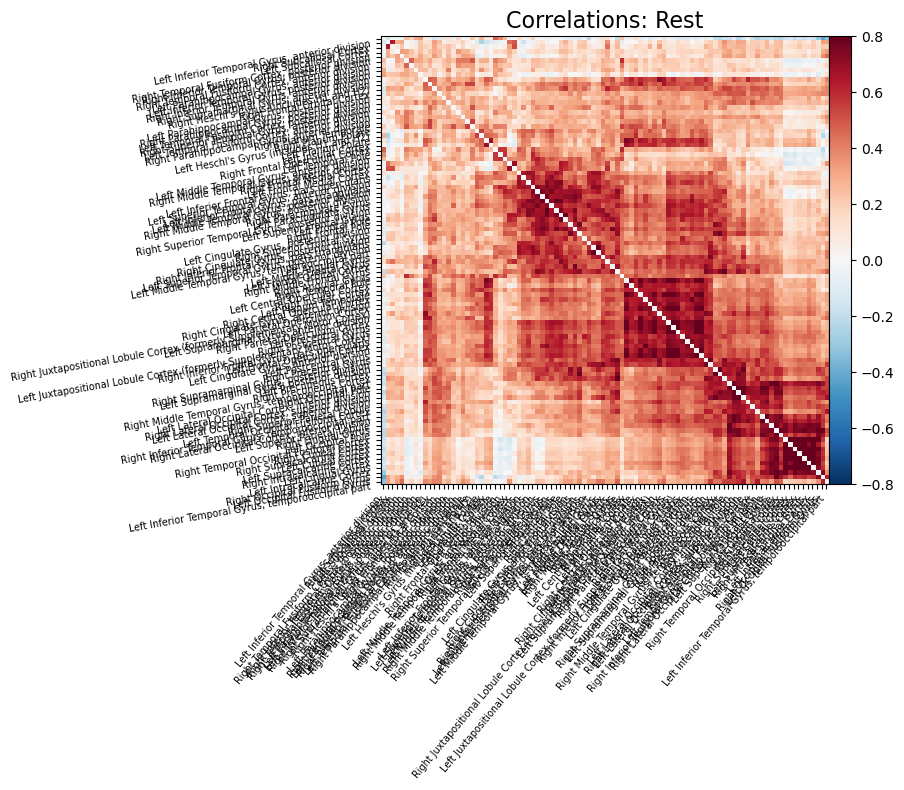

In [17]:
# Calculate the Connectivity for Rest
correlation_measure_rest = ConnectivityMeasure(
    kind="correlation",
    standardize="zscore_sample",
) 
correlation_matrix_rest = correlation_measure_rest.fit_transform([time_series_rest])[0]
# zero out the main diagonal
np.fill_diagonal(correlation_matrix_rest, 0)
# plot the correlation matrix
plotting.plot_matrix(
    correlation_matrix_rest,
    figure=(10,8),
    labels=labels[1:],
    vmax=.8,
    vmin=-.8,
    title="Correlations: Rest",
    reorder=True,
)



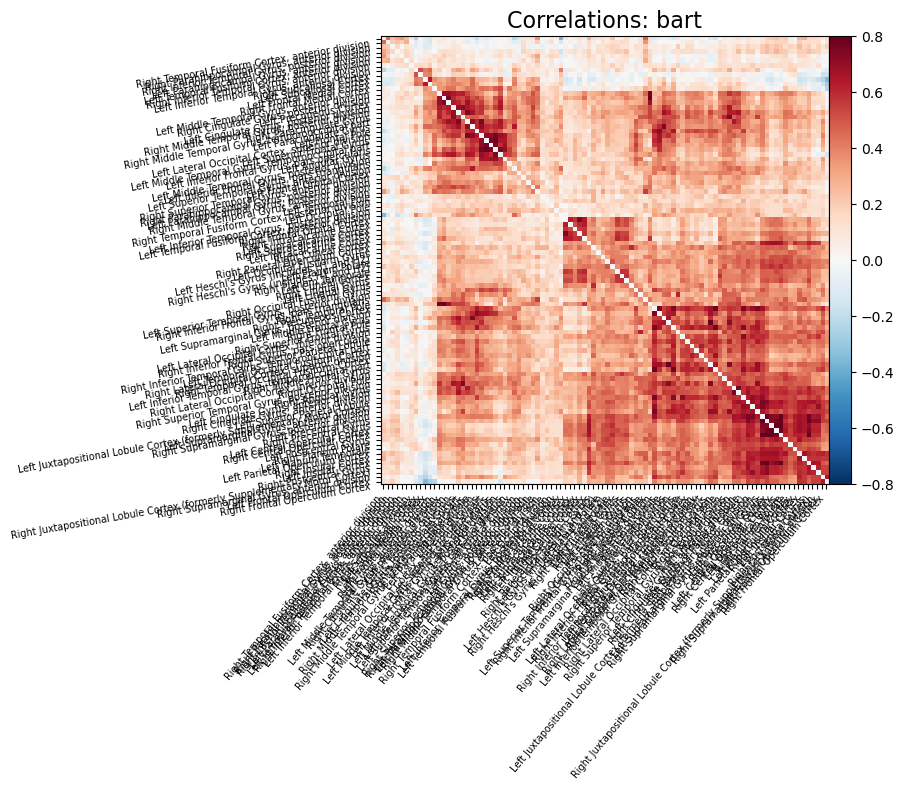

In [18]:
# Calculate the Connectivity for BART
# Calculate the Connectivity for bart
correlation_measure_bart = ConnectivityMeasure(
    kind="correlation",
    standardize="zscore_sample",
) 
correlation_matrix_bart = correlation_measure_bart.fit_transform([time_series_bart])[0]
# zero out the main diagonal
np.fill_diagonal(correlation_matrix_bart, 0)
# plot the correlation matrix
plotting.plot_matrix(
    correlation_matrix_bart,
    figure=(10,8),
    labels=labels[1:],
    vmax=.8,
    vmin=-.8,
    title="Correlations: bart",
    reorder=True,
)



## Connectome plots

Now that we have the pairwise correlations, we can plot the connectivity with the `plot_connectome` method. 

You'll want to apply an `edge_threshold="99%"` to make it so only the most connected areas are included.

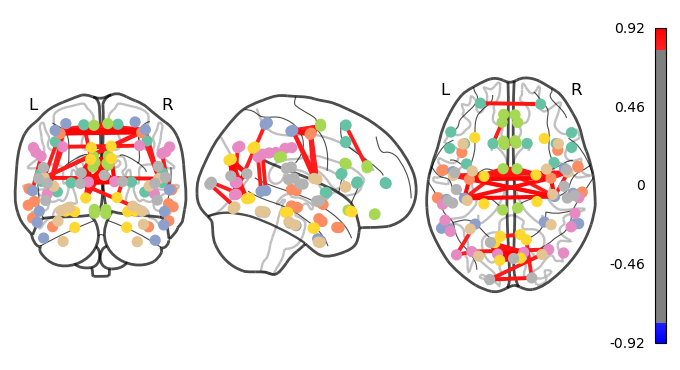

In [19]:
# Connectome plot of Rest
plotting.plot_connectome(
    correlation_matrix_rest,
    coords,
    edge_threshold="99%",
    colorbar=True,
)
plotting.show()

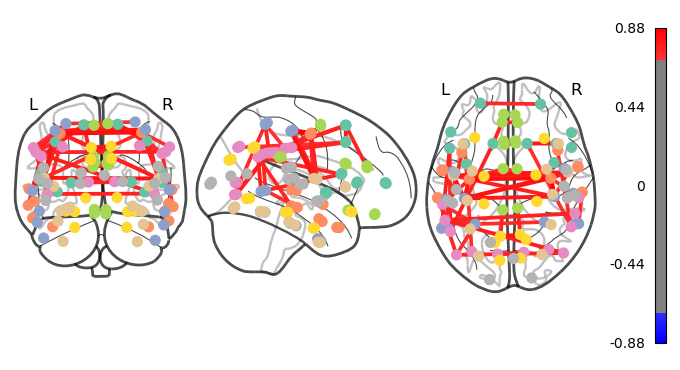

In [20]:
# Connectome plot of BART
plotting.plot_connectome(
    correlation_matrix_bart,
    coords,
    edge_threshold="99%",
    colorbar=True,
)
plotting.show()

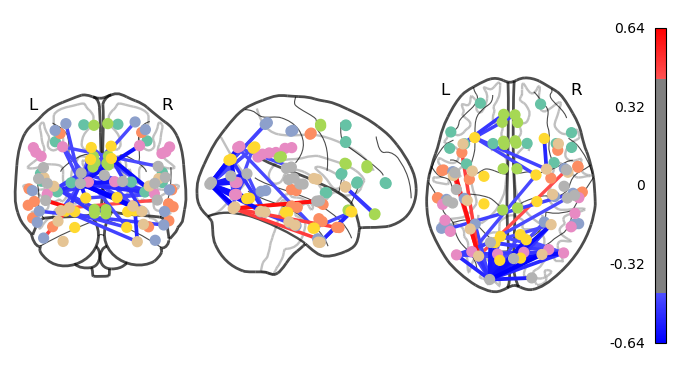

In [21]:
# Connectome plot of BART - Rest
plotting.plot_connectome(
    correlation_matrix_bart-correlation_matrix_rest,
    coords,
    edge_threshold="99%",
    colorbar=True,
)
plotting.show()

## Discussion

- Please write two or three bullet points describing what you found.
- What regions were most connected at rest? What about during the BART?
    - At rest, all of the most connected regions are positively correlated indicating activity in the pairs are similar.
    - Many of the paris are the left and right hemisphere nodes of the same region
    - During the BART, the connections were all positive as well.
    - There are the bilateral connections as well.
    - There are also several connections along the anterior posterior axis.
- What regions were most different between rest and BART?
    - There is much higher positive connectivity in and between the occipital lobe nodes in the rest condition (due to the subtracted correlations being negative).
    - Only a few edges were more positive in the BART and they are connecting the posterior (occipital?) region to the temporal lobes. 